In [7]:
include("sim.jl"); #include the simulator 
include("floopMap.jl") #include mapping

Import successful: sim.jl
Import successful: floopMap.jl


In [8]:
nSeg=5 #number of segments
aStep=3 #angle step 
aLimit=60
res=10 #resolution of segment 
l=1/res #set subsegment lenght so that segment lenght =1


0.1

In [1]:
### Begin continuous state space code
# s: 5 element column vector of joint angles
# a: 5 element column vector of action on each segment -> currently a[i] ∈ {-1, 0, 1}
# w: currently 9 element column vector of weights for value approximation

BasisSize = 9

global GoalPos, GoalThresh
GoalPos = [4.5,1]
GoalThresh = 0.3

0.3

In [16]:
function ContReward(s)
    
    eDec = 2 # exponential decay factor in the goal proximity
    
    EEpos = ccQuick(map(deg2rad, s), 1)[end,:]
    goalDist = norm(GoalPos - EEpos')
    
    (goalDist < GoalThresh) ? r = 1000 : r = 0
    #(goalDist < GoalThresh) ? r = 1000 : r = exp(-eDec*goalDist) # if within threshold of goal, return full reward. Otherwise, return negative exponential of distance to goal
    return r
end

ContReward (generic function with 1 method)

In [3]:
function ContTrans(s,a)
    #currently deterministic, finite action space
    return s + a #can make this probabilistic by sampling from distribution
end

ContTrans (generic function with 1 method)

In [4]:
function ValApprox(w, s)
    # features: EEpos, goalDist, s, const. (currently 10 elements) -> add ObstDist when obstacles added. And other bases?
    return sum(w.*BasisFun(s))
end

ValApprox (generic function with 1 method)

In [5]:
function BasisFun(s)
    
    EEpos = ccQuick(map(deg2rad, s'), 1)[end,:]
    goalDist = norm(GoalPos' - EEpos)
    return [EEpos'; goalDist; s'; 1]
    
end

BasisFun (generic function with 1 method)

In [23]:
m = 1000 # number of state samples
w = zeros(BasisSize) #initialize weights
aSize = 243 #number of possible actions
kMax = 1 # number of samples of probabilistic transition - currently 1 because deterministic transition
γ = 0.95 # learning rate
y = zeros(m)
action = [0 0 0 0 0]
#println(size(w))
#println(size(action))

stateMat = zeros(m,5)
for i = 1:m # set up this way so can change state initialization based on trajectory following
    stateMat[i, :] = [rand(-90:90) rand(-90:90) rand(-90:90) rand(-90:90) rand(-90:90)]
end

for iters = 1:50

    A = zeros(m,BasisSize)

    for i = 1:m
    
        q = zeros(aSize)
        state = stateMat[i,:]
        A[i,:] = BasisFun(state)

        for j = 1:aSize
            action[1],action[2],action[3],action[4],action[5] = ind2sub((3,3,3,3,3),j)
            action -=2
            for k = 1:kMax
                #println(ContReward(state))
                #println(ValApprox(w,ContTrans(state,action)))
                #println(w)
                q[j] += (ContReward(state) + γ*ValApprox(w,ContTrans(state,action)))/kMax
                #println("ok")
            end
        end

        y[i] = maximum(q)
    
    end

    wp = (pinv(A)*y)
    println(norm(wp - w))
    w = wp
end
    


304.19605187698176
292.22871483952525
280.5416800167654
269.13233545646216
257.99534633429295
247.12967725893438
236.53319591550058
226.19740443176815
216.11349467172352
206.28657085075452
196.71480524245015
187.40336149834067
178.34571127357322
169.5503702156268
161.0207784543575
152.75175447481826
144.74280787586466
136.98684564062955
129.48752221586167
122.22906974265184
115.21721822242824
108.45693714725124
101.93244819242669
95.63890495014769
89.58814487464886
83.77010373849795
78.189920661094
72.8446402549841
67.73846373511307
62.8653198198259
58.218020346401886
53.7943528858116
49.58468611616784
45.58725886244886
41.80262105684926
38.2227602604163
34.84500901892154
31.66216249029199
28.668943864535645
25.860981324916793
23.234062875595846
20.782522891737496
18.50669043682231
16.40517813923911
14.472695700604104
12.71248109921445
11.130208197999854
9.72998811024342
8.520740217865649
7.516678635163341


In [24]:
w

9-element Array{Float64,1}:
 -260.825   
  -37.8074  
 -878.963   
   -2.7603  
   -0.434771
   -1.08116 
   -0.550434
    0.140979
 5433.12    

In [25]:
s = [rand(-90:90) rand(-90:90) rand(-90:90) rand(-90:90) rand(-90:90)]
a = zeros(1,5)
p = zeros(200,2)
for i = 1:200
    
    println(norm(ccQuick(map(deg2rad, s), 1)[end,:] - [4.5 1]))
    p[i,:] = ccQuick(map(deg2rad, s), 1)[end,:]    
    
    q = zeros(aSize)
    for j = 1:243
        action[1],action[2],action[3],action[4],action[5] = ind2sub((3,3,3,3,3),j)
        action -=2
        
        q[j] += (ContReward(s) + γ*ValApprox(w,ContTrans(s,action)))
    end
    
    #println(q)
    
    a[1],a[2],a[3],a[4],a[5] = ind2sub((3,3,3,3,3),findmax(q)[2])
    a-= 2
    #println(a)
    s = ContTrans(s,a)
end

3.5870400337864488
3.4009793389790994
3.214357215677537
3.0275456057884007
2.840945919613893
2.6549982851995386
2.470194676054345
2.287097755161524
2.106368258068964
1.9288052766514427
1.7554061632131377
1.587456191830564
1.4266623582525886
1.2753484898558367
1.1367211631371494
1.0092597443906877
0.8988468095327754
0.8120302168326093
0.7389066513939463
0.6851438188424628
0.6351721675551074
0.5906239776323822
0.5475024825896955
0.5052592410490735
0.4639267345882918
0.4235407472920222
0.38414191818545335
0.34577815876981055
0.3085085365994292
0.26837591016565043
0.23226036582895332
0.19715659519783385
0.16309459869207255
0.13011514284437972
0.09828656563215234
0.06776420418092352
0.03910155323682584
0.017346769956780375
0.009385106117457654
0.0018813314833808865
0.0018813314833808865
0.0018813314833808865
0.0018813314833808865
0.0018813314833808865
0.0018813314833808865
0.0018813314833808865
0.0018813314833808865
0.0018813314833808865
0.0018813314833808865
0.0018813314833808865
0.0018813

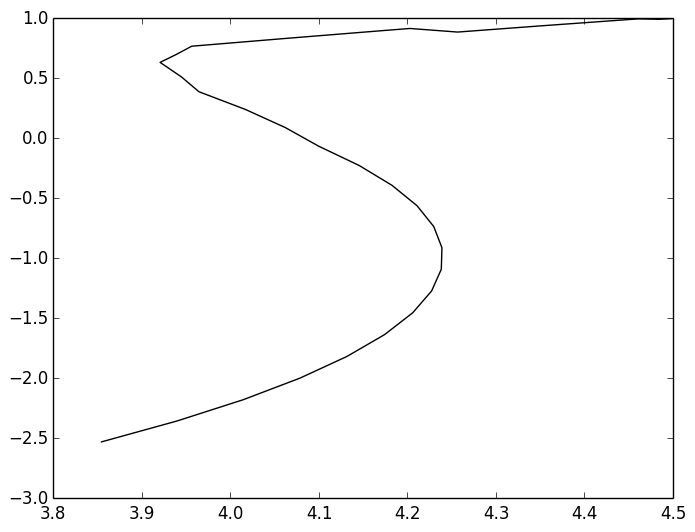

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11bdd4150>

In [26]:
using PyPlot
plot(p[:,1], p[:,2], "k")